In [1]:
import tensorflow as tf
import tools.datasets.mnist3 as mnist_tools
import tools.datasets.svhn as svhn_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch
from functools import partial

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
mnist_train_images, mnist_train_labels = mnist_tools.get_data('train')
mnist_test_images, mnist_test_labels = mnist_tools.get_data('test')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
mnist_test_images[0].shape

(28, 28, 3)

In [4]:
# labeled samples used per class
# sup_per_class = 10
sup_per_class = -1
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 100

learning_rate = 1e-4
decay_steps = 9000
decay_factor = 0.33
logit_weight = 1.0

max_steps = 1000
eval_interval = 100

log_dir = "logs/pretrained-mnist/pure-mnist"

seed = None

NUM_LABELS = 10

# [10 (classes), 10 (samples), 28, 28, 1]
sup_by_label = semisup.sample_by_label(mnist_train_images, mnist_train_labels,
                        sup_per_class, NUM_LABELS, seed)

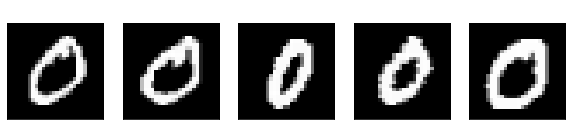

In [5]:
vis.imshow(sup_by_label[0][:5], channels=3, imgwidth=28, num_row=5)

In [6]:
TARGET_SHAPE = svhn_tools.IMAGE_SHAPE
TEST_SHAPE   = TARGET_SHAPE

IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE
new_shape   = TARGET_SHAPE
emb_size    = 128

In [7]:
from ipywidgets import IntProgress, Layout
from train import apply_envelope

graph = tf.Graph()


with graph.as_default():
    
    sup_data,sup_label = up.create_per_class_inputs_v2(sup_by_label, sup_per_batch)
    sup_it             = sup_data.repeat().make_one_shot_iterator()
    sup_it_label       = sup_label.repeat().make_one_shot_iterator()
    
    model_func = partial(
        arch.svhn_model,
        new_shape=new_shape,
        img_shape=IMAGE_SHAPE,
        emb_size=emb_size
    )
    
    model = semisup.SemisupModel(model_func, NUM_LABELS, IMAGE_SHAPE,
                                 test_in=tf.placeholder(np.float32, [None] + IMAGE_SHAPE, 'test_in')
                                )
    
    t_sup_images, t_sup_labels = tf.concat( sup_it.get_next(), 0), tf.concat( sup_it_label.get_next(), 0)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    model.add_logit_loss(t_sup_logit, t_sup_labels, weight=logit_weight)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver(max_to_keep=30)

---------
Variables: name (type shape) [size]
---------
net/conv1/weights:0 (float32_ref 3x3x3x32) [864, bytes: 3456]
net/conv1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_3/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_3/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_3/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_3/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:

In [19]:
test_images = mnist_test_images
test_labels = mnist_test_labels


from IPython.display import display

f = IntProgress(min=0, max=max_steps, layout= Layout(width="100%")) # instantiate the bar
display(f) # display the bar

sesh = tf.Session(graph = graph, config=tf.ConfigProto(intra_op_parallelism_threads=2, allow_soft_placement=True))

with sesh as sess:
    sess.run(tf.global_variables_initializer())
    
    epoch = 0
    
    for step in range(max_steps):
        _, summaries = sess.run([train_op, summary_op])
           
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step) % eval_interval == 0 or step == 99:
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {model.step}")
            saver.save(sess, log_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='100%'), max=1000)

Step: 0
[[ 228   22   57  623    9   35    6    0    0    0]
 [   3 1117    0    6    0    9    0    0    0    0]
 [  12  524    3  466    4   23    0    0    0    0]
 [   1   61    0  911    0   37    0    0    0    0]
 [   1  234    0  709    1   37    0    0    0    0]
 [  21  111    3  672    1   83    0    1    0    0]
 [   3  225    4  643    0   83    0    0    0    0]
 [   1  402    0  533    0   28    0   64    0    0]
 [  15  246    0  690    0   22    0    1    0    0]
 [   0  243    0  695    0   71    0    0    0    0]]
Test error: 75.93 %

saving model - step <tf.Variable 'global_step:0' shape=() dtype=int64_ref>
Step: 99
[[ 951    0    1    1    0    6    9    4    8    0]
 [   0 1111    4    3    1    1    6    0    9    0]
 [   9    0  977    6    5    1    9   12   13    0]
 [   3    2   20  901    0   42    1   19   20    2]
 [   1    0    6    0  895    0   13    2    9   56]
 [   3    0    6   17    3  850    5    1    5    2]
 [   9    3    2    0    7   24  906  

In [8]:
train_step = 901 
model_checkpoint = f"{log_dir}-{train_step}"

sampled_images = mnist_train_images[:2000]
sampled_label = mnist_train_labels[:2000]


with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sup_embedding = model.classify(sampled_images[sampled_label.argsort()])

INFO:tensorflow:Restoring parameters from logs/pretrained-mnist/pure-mnist-901


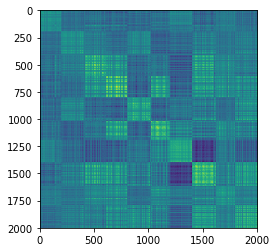

In [9]:
similarity = sup_embedding.dot(sup_embedding.T)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(similarity)

In [10]:
svhn_train_images, svhn_train_labels = svhn_tools.get_data('train')
svhn_test_images,  svhn_test_labels = svhn_tools.get_data('test')

In [11]:
sampled_svhn_images = svhn_train_images[:2000]
sampled_svhn_labels = svhn_train_labels[:2000]

In [12]:
graph_resize = tf.Graph()

with graph_resize.as_default():
    img_input = tf.placeholder(np.float32, [None, 32, 32, 3], "test_in")
    resized = tf.image.resize_images(
        img_input, tf.constant([28,28]),
        method=tf.image.ResizeMethod.BILINEAR
    )

with tf.Session(graph=graph_resize) as sess:
    output = sess.run(resized, feed_dict={img_input: sampled_svhn_images[sampled_svhn_labels.argsort()]})

In [13]:
output = output.astype(int)

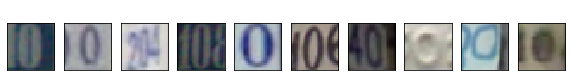

In [14]:
vis.imshow(output[:10], num_row=10, channels=3, imgwidth=28)

In [15]:
train_step = 901
with tf.Session(graph=graph) as sess:
    
    model_checkpoint = f"{log_dir}-{train_step}"
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    unsup_embedding = model.classify(output)

INFO:tensorflow:Restoring parameters from logs/pretrained-mnist/pure-mnist-901


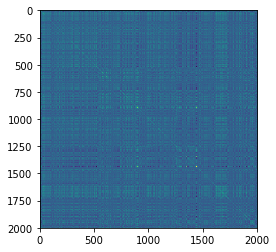

In [16]:
unsup_similarity = unsup_embedding.dot(unsup_embedding.T)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(unsup_similarity)

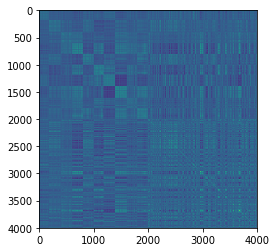

In [17]:
stacked = np.vstack( (sup_embedding, unsup_embedding))

stacked_similarity = stacked.dot(stacked.T)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(stacked_similarity)